crm.lead.list Total_count = 130
crm.deal.list Total_count = 5
user.get Total_count = 111
crm.status.list Total_count = 238


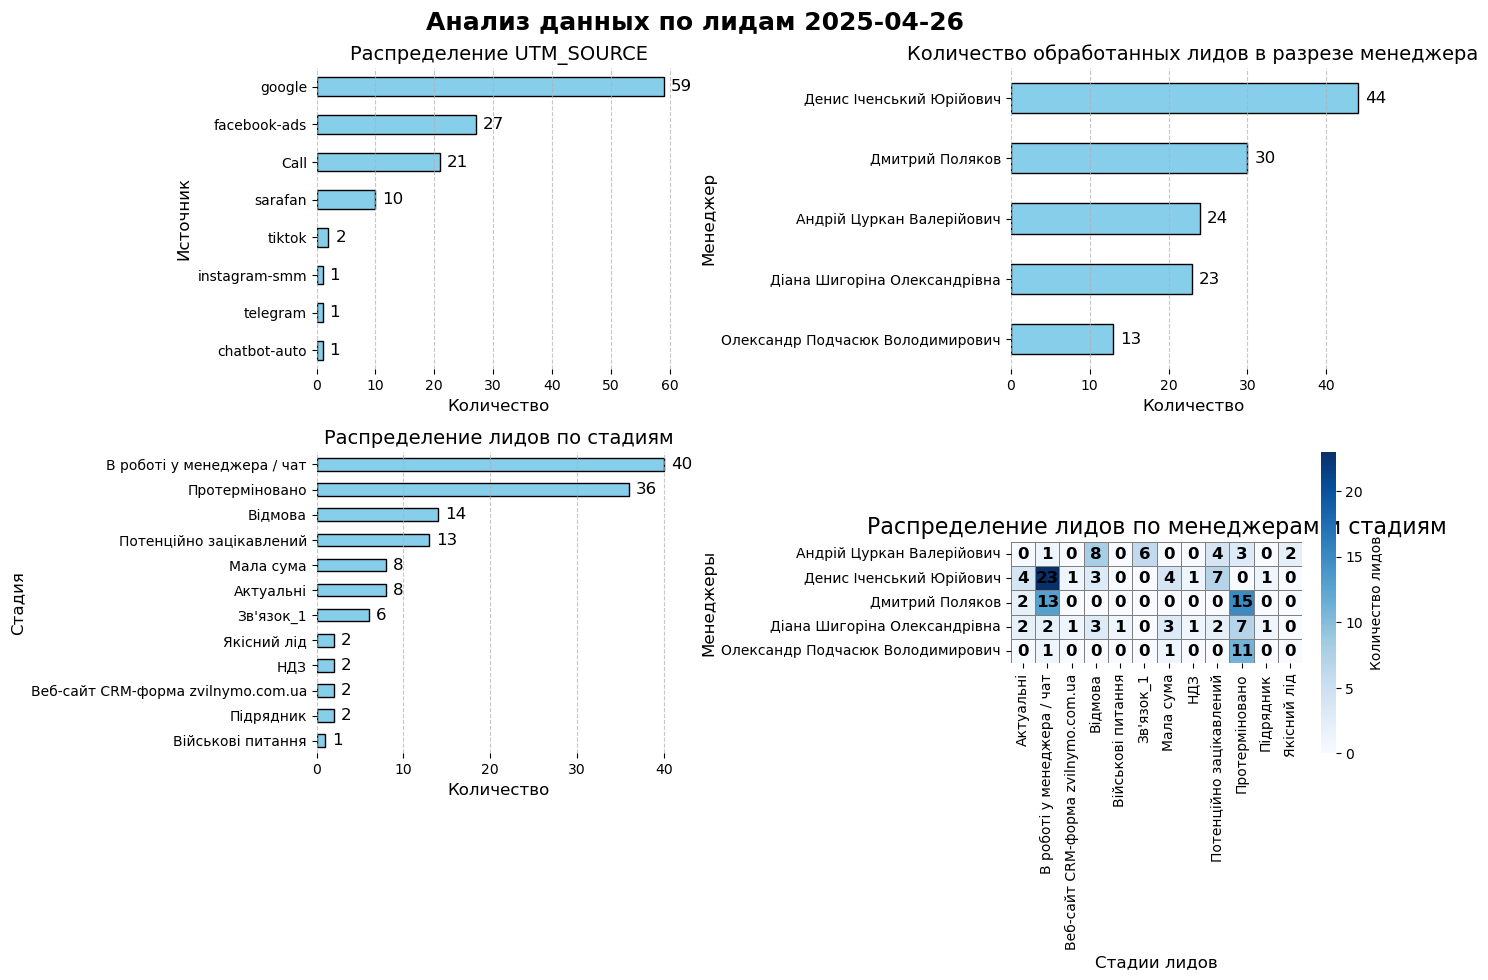

<Figure size 640x480 with 0 Axes>

In [7]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from b24 import B24
    

yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –ª–∏–¥–∞–º –∏–∑ –°RM
b24 = B24('ua.zvilnymo.com.ua', 596, 'l13ymwtftv37nmdq')
leads = b24.get_list('crm.lead.list', b24_filter={'>=DATE_CREATE': f'{yesterday}T00:00:01', '<=DATE_CREATE': f'{yesterday}T23:59:59'}, 
                    select=['ID','STATUS_ID','ASSIGNED_BY_ID','DATE_CREATE','UTM_SOURCE','UF_CRM_1745414446'])
leads_df = pd.DataFrame(leads)

leads_df['DATE_CREATE'] = pd.to_datetime(leads_df['DATE_CREATE'])
leads_df['taken_in_work'] = pd.to_datetime(leads_df['UF_CRM_1745414446'])
leads_df = leads_df.drop('UF_CRM_1745414446', axis=1)

# –í—ã—á–∏—Å–ª—è–µ–º —Ä–∞–∑–Ω–∏—Ü—É –≤–æ –≤—Ä–µ–º–µ–Ω–∏
leads_df['time_taken_in_work'] = leads_df['taken_in_work'] - leads_df['DATE_CREATE']

#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ —Å–¥–µ–ª–∫–∞–º –∏–∑ –°RM
category_id = 0

yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')

deal_filter = {
    "CATEGORY_ID": category_id, 
    ">=CLOSEDATE": f'{yesterday}T00:00:01',  
    "<=CLOSEDATE": f'{yesterday}T23:59:59',
    'STAGE_ID': 'WON'
}

select_fields = ["ID", "OPPORTUNITY", 'ASSIGNED_BY_ID', 'CLOSEDATE', 'UTM_SOURCE', 'UF_CRM_1695636781']  

deals = b24.get_list("crm.deal.list", b24_filter=deal_filter, select=select_fields)
deals_list = pd.DataFrame(deals)

#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –º–µ–Ω–µ–¥–∂–µ—Ä–∞–º –∏–∑ –°RM
b24 = B24('ua.zvilnymo.com.ua', 596, 'vt8sovzu4o2y28j7')
items_users = b24.get_list('user.get', select=['ID','NAME', 'LAST_NAME', 'SECOND_NAME'])
users_df = pd.DataFrame(items_users)[['ID', 'NAME', 'LAST_NAME', 'SECOND_NAME']]
users_df['FULL_NAME'] = users_df[['NAME', 'LAST_NAME', 'SECOND_NAME']].fillna('').agg(' '.join, axis=1).str.strip()
users_df = users_df[['ID', 'FULL_NAME']]

#–°—á–∏—Ç–∞—é –∫–æ–Ω–≤–µ—Ä—Å–∏–∏
agg_leads = leads_df.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count','time_taken_in_work':'median'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_leads'})

agg_deals = deals_list.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_deals'})

full_agg_data = agg_leads.merge(agg_deals,how='left', on='ASSIGNED_BY_ID')

datetime_cols = full_agg_data.select_dtypes(include=['datetime', 'datetimetz']).columns
for col in datetime_cols:
    median_value = full_agg_data[col].dropna().median()
    full_agg_data[col] = full_agg_data[col].fillna(median_value)

# –í—Å–µ –æ—Å—Ç–∞–ª—å–Ω—ã–µ (—á–∏—Å–ª–æ–≤—ã–µ, —Å—Ç—Ä–æ–∫–æ–≤—ã–µ –∏ —Ç.–ø.)
other_cols = full_agg_data.columns.difference(datetime_cols)
for col in other_cols:
    if pd.api.types.is_numeric_dtype(full_agg_data[col]):
        full_agg_data[col] = full_agg_data[col].fillna(0)
    else:
        full_agg_data[col] = full_agg_data[col].fillna('0')

full_agg_data['CR%'] = round(full_agg_data.number_of_deals/full_agg_data.number_of_leads,2) * 100
full_agg_data = full_agg_data.merge(users_df, left_on='ASSIGNED_BY_ID', right_on='ID')
full_agg_data = full_agg_data[['CR%','FULL_NAME','time_taken_in_work']]



#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ —Å—Ç–∞–¥–∏—è–º –∏–∑ –°RM
b24 = B24('ua.zvilnymo.com.ua', 596, 'hfyrvmf8dqrff3ph')
status_list = b24.get_list('crm.status.list', select=['ID','NAME'])
df_status = pd.DataFrame(status_list)
df_status = df_status[['STATUS_ID','NAME']]


#–û–±—ä–µ–¥–∏–Ω—è–º –¥–∞–Ω–Ω—ã–µ
leads_by_managers = leads_df.merge(users_df,how='inner', left_on='ASSIGNED_BY_ID', right_on='ID')
full_data = leads_by_managers.merge(df_status,how='inner', left_on='STATUS_ID', right_on='STATUS_ID') \
    .drop_duplicates()[['ID_x','DATE_CREATE','UTM_SOURCE','FULL_NAME','NAME']]
full_data = full_data.rename(columns={'ID_x':'ID_lead','FULL_NAME':'manager_name','NAME':'status_lead'})


# –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É —Å 2 —Å—Ç—Ä–æ–∫–∞–º–∏ –∏ 2 —Å—Ç–æ–ª–±—Ü–∞–º–∏
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# –ü–æ–ª—É—á–∞–µ–º —Ç–µ–∫—É—â—É—é –¥–∞—Ç—É –≤ —Ñ–æ—Ä–º–∞—Ç–µ –î–î.–ú–ú.–ì–ì–ì–ì
yesterday_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')


# –î–æ–±–∞–≤–ª—è–µ–º –æ–±—â–∏–π –∑–∞–≥–æ–ª–æ–≤–æ–∫ —Å –¥–∞—Ç–æ–π
fig.suptitle(f'–ê–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö –ø–æ –ª–∏–¥–∞–º {yesterday_date}', fontsize=18, fontweight='bold')

# 1-–π –≥—Ä–∞—Ñ–∏–∫: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ UTM_SOURCE
full_data.UTM_SOURCE.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ UTM_SOURCE', fontsize=14)
axes[0, 0].set_xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=12)
axes[0, 0].set_ylabel('–ò—Å—Ç–æ—á–Ω–∏–∫', fontsize=12)
axes[0, 0].tick_params(axis='y', rotation=0, labelsize=10)  # –£–º–µ–Ω—å—à–∞–µ–º —Ä–∞–∑–º–µ—Ä —à—Ä–∏—Ñ—Ç–∞
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 0].spines.values():
    spine.set_visible(False)

# 2-–π –≥—Ä–∞—Ñ–∏–∫: –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö —Å–¥–µ–ª–æ–∫ –≤ —Ä–∞–∑—Ä–µ–∑–µ –º–µ–Ω–µ–¥–∂–µ—Ä–∞ (–≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π)
full_data.manager_name.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 1], color='skyblue', edgecolor='black')
axes[0, 1].set_title('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö –ª–∏–¥–æ–≤ –≤ —Ä–∞–∑—Ä–µ–∑–µ –º–µ–Ω–µ–¥–∂–µ—Ä–∞', fontsize=14)
axes[0, 1].set_xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=12)
axes[0, 1].set_ylabel('–ú–µ–Ω–µ–¥–∂–µ—Ä', fontsize=12)
axes[0, 1].tick_params(axis='y', rotation=0, labelsize=10)  # –£–º–µ–Ω—å—à–∞–µ–º —Ä–∞–∑–º–µ—Ä —à—Ä–∏—Ñ—Ç–∞
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 1].spines.values():
    spine.set_visible(False)

# 3-–π –≥—Ä–∞—Ñ–∏–∫: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ª–∏–¥–æ–≤ –ø–æ —Å—Ç–∞–¥–∏—è–º (–≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π)
full_data.status_lead.value_counts(ascending=True).plot(kind='barh', ax=axes[1, 0], color='skyblue', edgecolor='black')
axes[1, 0].set_title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ª–∏–¥–æ–≤ –ø–æ —Å—Ç–∞–¥–∏—è–º', fontsize=14)
axes[1, 0].set_xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=12)
axes[1, 0].set_ylabel('–°—Ç–∞–¥–∏—è', fontsize=12)
axes[1, 0].tick_params(axis='y', rotation=0, labelsize=10)  # –£–º–µ–Ω—å—à–∞–µ–º —Ä–∞–∑–º–µ—Ä —à—Ä–∏—Ñ—Ç–∞
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[1, 0].spines.values():
    spine.set_visible(False)

# 4-–π –≥—Ä–∞—Ñ–∏–∫: Heatmap —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ª–∏–¥–æ–≤ –ø–æ –º–µ–Ω–µ–¥–∂–µ—Ä–∞–º –∏ —Å—Ç–∞–¥–∏—è–º
stage_by_manager_data = full_data.pivot_table(index='manager_name', 
                     columns='status_lead', 
                     values='ID_lead',  
                     aggfunc='count',  
                     fill_value=0) 

sns.heatmap(stage_by_manager_data, 
            annot=True,  
            fmt='d',     
            cmap='Blues',  
            cbar_kws={'label': '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª–∏–¥–æ–≤'},  
            annot_kws={"size": 12, "weight": 'bold', "color": 'black'},  
            linewidths=0.5,  
            linecolor='gray',  
            square=True, 
            ax=axes[1, 1])  # –ü—Ä–∏–º–µ–Ω—è–µ–º heatmap –Ω–∞ 4-–π –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫
axes[1, 1].set_title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ª–∏–¥–æ–≤ –ø–æ –º–µ–Ω–µ–¥–∂–µ—Ä–∞–º –∏ —Å—Ç–∞–¥–∏—è–º', fontsize=16)
axes[1, 1].set_xlabel('–°—Ç–∞–¥–∏–∏ –ª–∏–¥–æ–≤', fontsize=12)
axes[1, 1].set_ylabel('–ú–µ–Ω–µ–¥–∂–µ—Ä—ã', fontsize=12)

for spine in axes[1, 1].spines.values():
    spine.set_visible(False)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –¥–ª—è –∫–æ–º–ø–æ–Ω–æ–≤–∫–∏ –≥—Ä–∞—Ñ–∏–∫–æ–≤
plt.subplots_adjust(hspace=0.3)  # –£–≤–µ–ª–∏—á–∏–≤–∞–µ–º —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –º–µ–∂–¥—É —Å—Ç—Ä–æ–∫–∞–º–∏
plt.tight_layout()  # –°–∂–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –ª—É—á—à–µ–≥–æ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è
plt.show()

plt.tight_layout()  # –°–∂–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –ª—É—á—à–µ–≥–æ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è —á–µ—Ä–µ–∑ fig.savefig()
fig.savefig('output_image.png', bbox_inches='tight', dpi=300)



#–û—Ç–ø—Ä–∞–≤–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ –≤ —Ç–µ–ª–µ–≥—Ä–∞–º –±–æ—Ç–∞

TOKEN = "8024442492:AAEOg60JnXOC4OpIHqwAWeLwptQMrHwHQ3o"

chat_ids = [727013047, 718885452, 6775209607, 1139941966, 332270956]

def send_message(text, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage"
    for chat_id in chat_ids:
        requests.post(url, data={"chat_id": chat_id, "text": text, "parse_mode": "HTML"})

def send_graph_to_telegram(image_path, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendPhoto"
    for chat_id in chat_ids:
        with open(image_path, "rb") as photo:  # –û—Ç–∫—Ä—ã–≤–∞–µ–º —Ñ–∞–π–ª –≤–Ω—É—Ç—Ä–∏ —Ü–∏–∫–ª–∞
            requests.post(url, data={"chat_id": chat_id}, files={"photo": photo})
            
# –ü–æ–ª—É—á–∞–µ–º –º–µ–¥–∏–∞–Ω—É –≤—Ä–µ–º–µ–Ω–∏ –ø–æ –æ—Ç–¥–µ–ª—É
median_reaction = leads_df['time_taken_in_work'].median()
median_reaction_str = str(pd.to_timedelta(median_reaction)).split()[-1]
median_reaction_seconds = pd.to_timedelta(median_reaction).total_seconds()

message_text = (
    f"‚òÄÔ∏è –î–æ–±—Ä–æ–µ —É—Ç—Ä–æ!\n"
    f"üìä –≠—Ç–æ –æ—Ç—á–µ—Ç –∑–∞ <b>{yesterday_date}</b>.\n"
    f"üöÄ –í—á–µ—Ä–∞ –ø—Ä–∏–ª–µ—Ç–µ–ª–æ <b>{leads_df.shape[0]}</b> –ª–∏–¥–æ–≤.\n\n"
    f"üè¢ <b>–®–≤–∏–¥–∫—ñ—Å—Ç—å —Ä–µ–∞–∫—Ü—ñ—ó –ø–æ –≤—ñ–¥–¥—ñ–ª—É:</b> <b>{median_reaction_str}</b> "
    f"{'‚è∞' if median_reaction_seconds > 20 * 60 else ''}\n\n"
    f"<b>–ö–æ–Ω–≤–µ—Ä—Å–∏–∏ —Å –ª–∏–¥–∞ –≤ –ø—Ä–æ–¥–∞–∂—É –∏ –≤—Ä–µ–º—è —Ä–µ–∞–∫—Ü–∏–∏:</b>\n\n" +
    "\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n".join(
        f"üë§ <b>{row['FULL_NAME']}</b>\n"
        f"   CR%: <b>{row['CR%']}%</b> {'üî¥' if row['CR%'] < 0.1 else ''}\n"
        f"   –®–≤–∏–¥–∫—ñ—Å—Ç—å —Ä–µ–∞–∫—Ü—ñ—ó: <b>{str(pd.to_timedelta(row['time_taken_in_work'])).split()[-1]}</b> "
        f"{'‚è∞' if pd.to_timedelta(row['time_taken_in_work']).total_seconds() > 20*60 else ''}"
        for _, row in full_agg_data.iterrows()
    )
)




send_graph_to_telegram("C:/Users/–ê–Ω–¥—Ä–µ–π/computer/Desktop/Zvilnymo_analytics/leads_project/output_image.png", chat_ids)
send_message(message_text, chat_ids)

In [16]:
#CR2
round(deals_list.shape[0]/leads_df[leads_df['STATUS_ID']=='CONVERTED'].shape[0]*100,2)

32.69

In [17]:
#CR1
round(leads_df[leads_df['STATUS_ID']=='CONVERTED'].shape[0]/leads_df.shape[0]*100,2)

13.42

In [18]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from b24 import B24
    

today = datetime.today()

# –î–µ–Ω—å –Ω–µ–¥–µ–ª–∏ —Å–µ–≥–æ–¥–Ω—è (0 ‚Äî –ø–æ–Ω–µ–¥–µ–ª—å–Ω–∏–∫, 6 ‚Äî –≤–æ—Å–∫—Ä–µ—Å–µ–Ω—å–µ)
weekday = today.weekday()

# –ù–∞—Ö–æ–¥–∏–º –ø–æ–Ω–µ–¥–µ–ª—å–Ω–∏–∫ –ø—Ä–µ–¥—ã–¥—É—â–µ–π –Ω–µ–¥–µ–ª–∏
start_date = today - timedelta(days=weekday + 7)
# –í–æ—Å–∫—Ä–µ—Å–µ–Ω—å–µ –ø—Ä–µ–¥—ã–¥—É—â–µ–π –Ω–µ–¥–µ–ª–∏
end_date = start_date + timedelta(days=6)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ –Ω—É–∂–Ω—ã–π —Ñ–æ—Ä–º–∞—Ç
start_str = start_date.strftime('%Y-%m-%dT00:00:01')
end_str = end_date.strftime('%Y-%m-%dT23:59:59')

#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –ª–∏–¥–∞–º –∏–∑ –°RM
b24 = B24('ua.zvilnymo.com.ua', 596, 'l13ymwtftv37nmdq')
leads = b24.get_list('crm.lead.list', b24_filter={'>=DATE_CREATE': f'{start_str}', '<=DATE_CREATE': f'{end_str}'}, 
                    select=['ID','STATUS_ID','ASSIGNED_BY_ID','DATE_CREATE','UTM_SOURCE','UF_CRM_1745414446'])
leads_df = pd.DataFrame(leads)

leads_df['DATE_CREATE'] = pd.to_datetime(leads_df['DATE_CREATE'])
leads_df['taken_in_work'] = pd.to_datetime(leads_df['UF_CRM_1745414446'])
leads_df = leads_df.drop('UF_CRM_1745414446', axis=1)

# –í—ã—á–∏—Å–ª—è–µ–º —Ä–∞–∑–Ω–∏—Ü—É –≤–æ –≤—Ä–µ–º–µ–Ω–∏
leads_df['time_taken_in_work'] = leads_df['taken_in_work'] - leads_df['DATE_CREATE']

#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ —Å–¥–µ–ª–∫–∞–º –∏–∑ –°RM
category_id = 0

deal_filter = {
    "CATEGORY_ID": category_id, 
    ">=CLOSEDATE": f'{start_str}',  
    "<=CLOSEDATE": f'{end_str}',
    'STAGE_ID': 'WON'
}

select_fields = ["ID", "OPPORTUNITY", 'ASSIGNED_BY_ID', 'CLOSEDATE', 'UTM_SOURCE', 'UF_CRM_1695636781']  

deals = b24.get_list("crm.deal.list", b24_filter=deal_filter, select=select_fields)
deals_list = pd.DataFrame(deals)

#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –º–µ–Ω–µ–¥–∂–µ—Ä–∞–º –∏–∑ –°RM
b24 = B24('ua.zvilnymo.com.ua', 596, 'vt8sovzu4o2y28j7')
items_users = b24.get_list('user.get', select=['ID'])
users_df = pd.DataFrame(items_users)[['ID', 'NAME', 'LAST_NAME', 'SECOND_NAME']]
users_df['FULL_NAME'] = users_df[['NAME', 'LAST_NAME', 'SECOND_NAME']].fillna('').agg(' '.join, axis=1).str.strip()
users_df = users_df[['ID', 'FULL_NAME']]

#–°—á–∏—Ç–∞—é –∫–æ–Ω–≤–µ—Ä—Å–∏–∏
agg_leads = leads_df.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count','time_taken_in_work':'median'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_leads'})

agg_deals = deals_list.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_deals'})

full_agg_data = agg_leads.merge(agg_deals,how='left', on='ASSIGNED_BY_ID')

datetime_cols = full_agg_data.select_dtypes(include=['datetime', 'datetimetz']).columns
for col in datetime_cols:
    median_value = full_agg_data[col].dropna().median()
    full_agg_data[col] = full_agg_data[col].fillna(median_value)

# –í—Å–µ –æ—Å—Ç–∞–ª—å–Ω—ã–µ (—á–∏—Å–ª–æ–≤—ã–µ, —Å—Ç—Ä–æ–∫–æ–≤—ã–µ –∏ —Ç.–ø.)
other_cols = full_agg_data.columns.difference(datetime_cols)
for col in other_cols:
    if pd.api.types.is_numeric_dtype(full_agg_data[col]):
        full_agg_data[col] = full_agg_data[col].fillna(0)
    else:
        full_agg_data[col] = full_agg_data[col].fillna('0')

full_agg_data['CR%'] = round(full_agg_data.number_of_deals/full_agg_data.number_of_leads,2) * 100
full_agg_data = full_agg_data.merge(users_df, left_on='ASSIGNED_BY_ID', right_on='ID')
full_agg_data = full_agg_data[['CR%','FULL_NAME','time_taken_in_work']]



#–í—ã–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ —Å—Ç–∞–¥–∏—è–º –∏–∑ –°RM
b24 = B24('ua.zvilnymo.com.ua', 596, 'hfyrvmf8dqrff3ph')
status_list = b24.get_list('crm.status.list', select=['ID','NAME'])
df_status = pd.DataFrame(status_list)
df_status = df_status[['STATUS_ID','NAME']]


#–û–±—ä–µ–¥–∏–Ω—è–º –¥–∞–Ω–Ω—ã–µ
leads_by_managers = leads_df.merge(users_df,how='inner', left_on='ASSIGNED_BY_ID', right_on='ID')
full_data = leads_by_managers.merge(df_status,how='inner', left_on='STATUS_ID', right_on='STATUS_ID') \
    .drop_duplicates()[['ID_x','DATE_CREATE','UTM_SOURCE','FULL_NAME','NAME']]
full_data = full_data.rename(columns={'ID_x':'ID_lead','FULL_NAME':'manager_name','NAME':'status_lead'})


# –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É —Å 2 —Å—Ç—Ä–æ–∫–∞–º–∏ –∏ 2 —Å—Ç–æ–ª–±—Ü–∞–º–∏
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# –ü–æ–ª—É—á–∞–µ–º —Ç–µ–∫—É—â—É—é –¥–∞—Ç—É –≤ —Ñ–æ—Ä–º–∞—Ç–µ –î–î.–ú–ú.–ì–ì–ì–ì
yesterday_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')


# –î–æ–±–∞–≤–ª—è–µ–º –æ–±—â–∏–π –∑–∞–≥–æ–ª–æ–≤–æ–∫ —Å –¥–∞—Ç–æ–π
fig.suptitle(f'–ê–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö –ø–æ –ª–∏–¥–∞–º {yesterday_date}', fontsize=18, fontweight='bold')

# 1-–π –≥—Ä–∞—Ñ–∏–∫: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ UTM_SOURCE
full_data.UTM_SOURCE.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ UTM_SOURCE', fontsize=14)
axes[0, 0].set_xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=12)
axes[0, 0].set_ylabel('–ò—Å—Ç–æ—á–Ω–∏–∫', fontsize=12)
axes[0, 0].tick_params(axis='y', rotation=0, labelsize=10)  # –£–º–µ–Ω—å—à–∞–µ–º —Ä–∞–∑–º–µ—Ä —à—Ä–∏—Ñ—Ç–∞
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 0].spines.values():
    spine.set_visible(False)

# 2-–π –≥—Ä–∞—Ñ–∏–∫: –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö —Å–¥–µ–ª–æ–∫ –≤ —Ä–∞–∑—Ä–µ–∑–µ –º–µ–Ω–µ–¥–∂–µ—Ä–∞ (–≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π)
full_data.manager_name.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 1], color='skyblue', edgecolor='black')
axes[0, 1].set_title('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö –ª–∏–¥–æ–≤ –≤ —Ä–∞–∑—Ä–µ–∑–µ –º–µ–Ω–µ–¥–∂–µ—Ä–∞', fontsize=14)
axes[0, 1].set_xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=12)
axes[0, 1].set_ylabel('–ú–µ–Ω–µ–¥–∂–µ—Ä', fontsize=12)
axes[0, 1].tick_params(axis='y', rotation=0, labelsize=10)  # –£–º–µ–Ω—å—à–∞–µ–º —Ä–∞–∑–º–µ—Ä —à—Ä–∏—Ñ—Ç–∞
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 1].spines.values():
    spine.set_visible(False)

# 3-–π –≥—Ä–∞—Ñ–∏–∫: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ª–∏–¥–æ–≤ –ø–æ —Å—Ç–∞–¥–∏—è–º (–≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π)
full_data.status_lead.value_counts(ascending=True).plot(kind='barh', ax=axes[1, 0], color='skyblue', edgecolor='black')
axes[1, 0].set_title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ª–∏–¥–æ–≤ –ø–æ —Å—Ç–∞–¥–∏—è–º', fontsize=14)
axes[1, 0].set_xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=12)
axes[1, 0].set_ylabel('–°—Ç–∞–¥–∏—è', fontsize=12)
axes[1, 0].tick_params(axis='y', rotation=0, labelsize=10)  # –£–º–µ–Ω—å—à–∞–µ–º —Ä–∞–∑–º–µ—Ä —à—Ä–∏—Ñ—Ç–∞
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[1, 0].spines.values():
    spine.set_visible(False)

# 4-–π –≥—Ä–∞—Ñ–∏–∫: Heatmap —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ª–∏–¥–æ–≤ –ø–æ –º–µ–Ω–µ–¥–∂–µ—Ä–∞–º –∏ —Å—Ç–∞–¥–∏—è–º
stage_by_manager_data = full_data.pivot_table(index='manager_name', 
                     columns='status_lead', 
                     values='ID_lead',  
                     aggfunc='count',  
                     fill_value=0) 

sns.heatmap(stage_by_manager_data, 
            annot=True,  
            fmt='d',     
            cmap='Blues',  
            cbar_kws={'label': '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª–∏–¥–æ–≤'},  
            annot_kws={"size": 12, "weight": 'bold', "color": 'black'},  
            linewidths=0.5,  
            linecolor='gray',  
            square=True, 
            ax=axes[1, 1])  # –ü—Ä–∏–º–µ–Ω—è–µ–º heatmap –Ω–∞ 4-–π –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫
axes[1, 1].set_title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ª–∏–¥–æ–≤ –ø–æ –º–µ–Ω–µ–¥–∂–µ—Ä–∞–º –∏ —Å—Ç–∞–¥–∏—è–º', fontsize=16)
axes[1, 1].set_xlabel('–°—Ç–∞–¥–∏–∏ –ª–∏–¥–æ–≤', fontsize=12)
axes[1, 1].set_ylabel('–ú–µ–Ω–µ–¥–∂–µ—Ä—ã', fontsize=12)

for spine in axes[1, 1].spines.values():
    spine.set_visible(False)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –¥–ª—è –∫–æ–º–ø–æ–Ω–æ–≤–∫–∏ –≥—Ä–∞—Ñ–∏–∫–æ–≤
plt.subplots_adjust(hspace=0.3)  # –£–≤–µ–ª–∏—á–∏–≤–∞–µ–º —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –º–µ–∂–¥—É —Å—Ç—Ä–æ–∫–∞–º–∏
plt.tight_layout()  # –°–∂–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –ª—É—á—à–µ–≥–æ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è
plt.show()

plt.tight_layout()  # –°–∂–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –ª—É—á—à–µ–≥–æ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è —á–µ—Ä–µ–∑ fig.savefig()
fig.savefig('output_image.png', bbox_inches='tight', dpi=300)



#–û—Ç–ø—Ä–∞–≤–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ –≤ —Ç–µ–ª–µ–≥—Ä–∞–º –±–æ—Ç–∞

TOKEN = "8024442492:AAEOg60JnXOC4OpIHqwAWeLwptQMrHwHQ3o"

chat_ids = [727013047]

def send_message(text, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage"
    for chat_id in chat_ids:
        requests.post(url, data={"chat_id": chat_id, "text": text, "parse_mode": "HTML"})

def send_graph_to_telegram(image_path, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendPhoto"
    for chat_id in chat_ids:
        with open(image_path, "rb") as photo:  # –û—Ç–∫—Ä—ã–≤–∞–µ–º —Ñ–∞–π–ª –≤–Ω—É—Ç—Ä–∏ —Ü–∏–∫–ª–∞
            requests.post(url, data={"chat_id": chat_id}, files={"photo": photo})
            
# –ü–æ–ª—É—á–∞–µ–º –º–µ–¥–∏–∞–Ω—É –≤—Ä–µ–º–µ–Ω–∏ –ø–æ –æ—Ç–¥–µ–ª—É
median_reaction = leads_df['time_taken_in_work'].median()
median_reaction_str = str(pd.to_timedelta(median_reaction)).split()[-1]
median_reaction_seconds = pd.to_timedelta(median_reaction).total_seconds()

message_text = (
    f"‚òÄÔ∏è –î–æ–±—Ä–∏–π —Ä–∞–Ω–æ–∫!\n" 
    f"üìä –¶–µ –∑–≤—ñ—Ç –∑–∞ <b>{yesterday_date}</b>.\n" 
    f"üöÄ –ó–∞ –º–∏–Ω—É–ª–∏–π —Ç–∏–∂–¥–µ–Ω—å –≤ —Å–∏—Å—Ç–µ–º—É –∑–∞–ª–µ—Ç—ñ–ª–æ <b>{leads_df.shape[0]}</b> –ª—ñ–¥—ñ–≤.\n\n" 

    f"üìà <b>–ü–æ–∫–∞–∑–Ω–∏–∫–∏ –ø–æ –≤—ñ–¥–¥—ñ–ª—É:</b>\n"
    f"   ‚Ä¢ CR1 (–∫–æ–Ω–≤–µ—Ä—Å—ñ—è –≤ —É–≥–æ–¥—É): <b>{round(leads_df[leads_df['STATUS_ID'] == 'CONVERTED'].shape[0] / leads_df.shape[0] * 100, 2)}%</b>\n"
    f"   ‚Ä¢ CR2 (–∫–æ–Ω–≤–µ—Ä—Å—ñ—è –≤ —É—Å–ø—ñ—à–Ω—É —É–≥–æ–¥—É): <b>{round(deals_list.shape[0] / leads_df[leads_df['STATUS_ID'] == 'CONVERTED'].shape[0] * 100, 2)}%</b>\n\n"

    f"üè¢ <b>–®–≤–∏–¥–∫—ñ—Å—Ç—å —Ä–µ–∞–∫—Ü—ñ—ó –ø–æ –≤—ñ–¥–¥—ñ–ª—É:</b> <b>{median_reaction_str}</b> "
    f"{'‚è∞' if median_reaction_seconds > 20 * 60 else ''}\n\n"

    f"<b>–ö–æ–Ω–≤–µ—Ä—Å—ñ—ó –∑ –ª—ñ–¥–∞ –≤ –ø—Ä–æ–¥–∞–∂ —Ç–∞ —à–≤–∏–¥–∫—ñ—Å—Ç—å —Ä–µ–∞–∫—Ü—ñ—ó:</b>\n\n" +
    "\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n".join(
        f"üë§ <b>{row['FULL_NAME']}</b>\n"
        f"   CR%: <b>{row['CR%']}%</b> {'üî¥' if row['CR%'] < 0.1 else ''}\n"
        f"   –®–≤–∏–¥–∫—ñ—Å—Ç—å —Ä–µ–∞–∫—Ü—ñ—ó: <b>{str(pd.to_timedelta(row['time_taken_in_work'])).split()[-1]}</b> "
        f"{'‚è∞' if pd.to_timedelta(row['time_taken_in_work']).total_seconds() > 20*60 else ''}"
        for _, row in full_agg_data.iterrows()
    )
)



send_graph_to_telegram("C:/Users/–ê–Ω–¥—Ä–µ–π/computer/Desktop/Zvilnymo_analytics/leads_project/output_image.png", chat_ids)
send_message(message_text, chat_ids)

crm.lead.list Total_count = 775


TypeError: Cannot subtract tz-naive and tz-aware datetime-like objects.